In [1]:
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

%matplotlib inline

In [2]:
def compute_constellation_map_naive(Y, dist_freq=7, dist_time=7, thresh=0.01):
    # spectrogram dimensions
    if Y.ndim > 1:
        (K, N) = Y.shape
    else:
        K = Y.shape[0]
        N = 1
    Cmap = np.zeros((K, N), dtype=np.bool8)

    # loop over spectrogram
    for k in range(K):
        f1 = max(k - dist_freq, 0)
        f2 = min(k + dist_freq + 1, K)
        for n in range(N):
            t1 = max(n - dist_time, 0)
            t2 = min(n + dist_time + 1, N)
            curr_mag = Y[k, n]
            curr_rect = Y[f1:f2, t1:t2]
            c_max = np.max(curr_rect)
            if ((curr_mag == c_max) and (curr_mag > thresh)):
                Cmap[k, n] = True
    return Cmap

In [7]:
def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im

In [4]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024):
    x, Fs = librosa.load(fn_wav, Fs)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.abs(X)
    return Y

In [5]:
# Load the .mp3 file 
Fs = 22050
rbdys_angyil_clip = os.path.join('..', 'Data', 'Red Bull Dance Your Style 2022', 'Angyil', 'Angyil_clip.mp3')
rbdys_lauren_hill = os.path.join('..', 'Data', 'Red Bull Dance Your Style 2022', 'Angyil', 'Lauryn Hill - Doo Wop (That Thing) (Official HD Video).mp3')

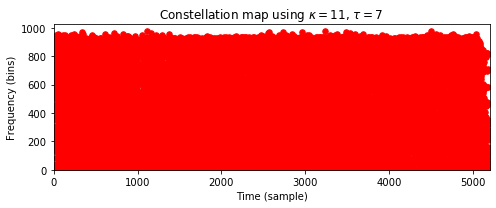

In [9]:
Y_song = compute_spectrogram(rbdys_lauren_hill)

dist_freq = 11  # kappa: neighborhood in frequency direction
dist_time = 7   # tau: neighborhood in time direction
title=r'Constellation map using $\kappa=%d$, $\tau=%d$' % (dist_freq, dist_time)
Cmap_naive = compute_constellation_map_naive(Y_song, dist_freq, dist_time)
fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y_song), 
                                     color='r', s=30, title=title)

In [10]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

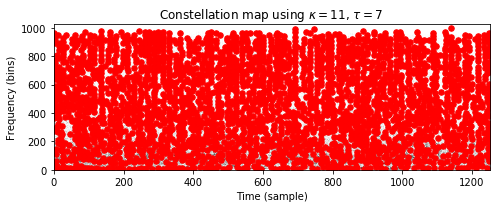

In [15]:
Y_clip = compute_spectrogram(rbdys_angyil_clip)

dist_freq = 11  # kappa: neighborhood in frequency direction
dist_time = 7   # tau: neighborhood in time direction
title=r'Constellation map using $\kappa=%d$, $\tau=%d$' % (dist_freq, dist_time)
Cmap_naive = compute_constellation_map_naive(Y_clip, dist_freq, dist_time)
fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y_clip), 
                                     color='r', s=30, title=title)

In [12]:
def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0):
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    # Expand C_est with 2D-max-filter using the tolerance parameters
    C_est_max = ndimage.maximum_filter(C_est, size=(2*tol_freq+1, 2*tol_time+1),
                                       mode='constant')
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND

In [13]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L -N
    assert M >= 0, "Query must be shorter than document"
    Delta = np.zeros(L)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m+N]
        TP, FN, FP, C_AND = match_binary_matrices_tol(C_D_crop, C_Q,
                                                      tol_freq=tol_freq, tol_time=tol_time)
        Delta[m] = TP
    shift_max = np.argmax(Delta)
    return Delta, shift_max

In [14]:
def plot_signal(x, Fs=1, T_coef=None, ax=None, figsize=(6, 2), xlabel='Time (seconds)', ylabel='', title='', dpi=72,
                ylim=True, **kwargs):
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1, 1, 1)
    if T_coef is None:
        T_coef = np.arange(x.shape[0]) / Fs

    if 'color' not in kwargs:
        kwargs['color'] = 'gray'

    line = ax.plot(T_coef, x, **kwargs)

    ax.set_xlim([T_coef[0], T_coef[-1]])
    if ylim is True:
        ylim_x = x[np.isfinite(x)]
        x_min, x_max = ylim_x.min(), ylim_x.max()
        if x_max == x_min:
            x_max = x_max + 1
        ax.set_ylim([min(1.1 * x_min, 0.9 * x_min), max(1.1 * x_max, 0.9 * x_max)])
    elif ylim not in [True, False, None]:
        ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if fig is not None:
        plt.tight_layout()

    return fig, ax, line

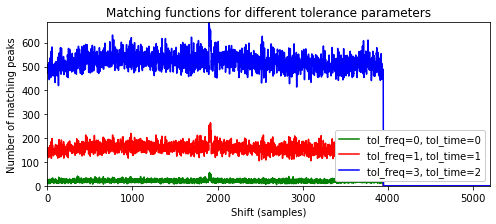

In [16]:
Y_D = compute_spectrogram(rbdys_lauren_hill)
Cmap_D = compute_constellation_map_naive(Y_D)

Y_Q = compute_spectrogram(rbdys_angyil_clip)
Cmap_Q = compute_constellation_map_naive(Y_Q)

Delta_0, shift_max_0 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=0, tol_time=0)
Delta_1, shift_max_1 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=1, tol_time=1)
Delta_2, shift_max_2 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=3, tol_time=2)

y_max = Delta_2[shift_max_2] + 1
fig, ax, line = plot_signal(Delta_0, ylim=[0, y_max], color='g',
                                     xlabel='Shift (samples)', ylabel='Number of matching peaks', 
                                     figsize=(7, 3))
plt.title('Matching functions for different tolerance parameters')
ax.plot(Delta_1, color='r')
ax.plot(Delta_2, color='b')
plt.legend(['tol_freq=0, tol_time=0', 'tol_freq=1, tol_time=1', 
            'tol_freq=3, tol_time=2'], loc='lower right', framealpha=1)
plt.show()

In [17]:
def plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=0):
    Cmap_Q_extend = np.zeros(Cmap_D.shape) 
    Cmap_Q_extend[:, shift:shift+Cmap_Q.shape[1]] = Cmap_Q
    TP, FN, FP, Cmap_AND = match_binary_matrices_tol(Cmap_D, Cmap_Q_extend, 
                                                     tol_freq=1, tol_time=1)
    title=r'Matching result for shift index m=%d (TP=%d)' % (shift, TP)
    fig, ax, im = plot_constellation_map(Cmap_AND, color='green', s=200, marker='+', title=title)
    n, k = np.argwhere(Cmap_D == 1).T
    ax.scatter(k, n, color='r', s=50, marker='o')
    n, k = np.argwhere(Cmap_Q_extend == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    plt.legend(['Matches (TP)', 'Reference', 'Estimated'], loc='upper right', framealpha=1)
    plt.show()

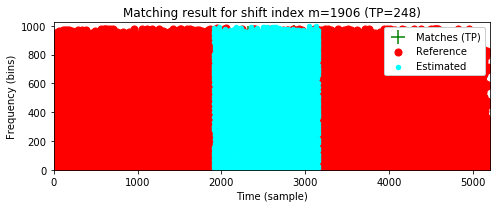

In [18]:
shift = np.argmax(Delta_0)
plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=shift)    